In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim.lr_scheduler as lr_scheduler

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os
import argparse
import time

from lib import models
import math

import numpy as np
import scipy as sp
import scipy.sparse.linalg as linalg
from scipy.sparse import csgraph
import scipy.sparse as sparse

import matplotlib.pyplot as plt
import easydict as edict
import datetime

from multiprocessing import Pool
import logging
logger = logging.getLogger()
# fhandler = logging.FileHandler(filename='mylog.log', mode='a')
fhandler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

2019-06-24 22:43:12,375 - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# parameters
args = edict

# imagenet
args.cache = '../checkpoint/train_features_labels_cache/instance_imagenet_train_feature_resnet50.pth.tar'
args.similarity_cache_dir = '../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract'
args.save_path = '../checkpoint/pseudos_imagenet/instance_imagenet_nc_resnet50'
os.makedirs(args.save_path, exist_ok=True)

args.low_dim = 128
args.num_class = 1000
args.rng_seed = 0

In [3]:
ckpt = torch.load(args.cache)
train_labels, train_features = ckpt['labels'], ckpt['features']

logger.info(train_features.shape)
logger.info(train_labels.shape)

2019-06-24 22:43:16,286 - torch.Size([1281167, 128])
2019-06-24 22:43:16,291 - torch.Size([1281167])


# use cpu because the follow computation need a lot of memory

In [4]:
device = 'cpu'
train_features, train_labels = train_features.to(device), train_labels.to(device)

In [5]:
num_train_data = train_labels.shape[0]
num_class = torch.max(train_labels) + 1

torch.manual_seed(args.rng_seed)
torch.cuda.manual_seed_all(args.rng_seed)
perm = torch.randperm(num_train_data).to(device)
logger.info(perm)

2019-06-24 22:43:16,745 - tensor([1069931,  571398,  762430,  ...,  615438,  152445,  922209])


# constrained normalized cut

In [6]:
def make_column_normalize(X):
    return X.div(torch.norm(X, p=2, dim=0, keepdim=True))

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def get_sim_idx(feature, K, cache_dir='./cache'):
    n = feature.shape[0]
    chunk_size= min(10** 9 // n, n)
    n_chunks = math.ceil(n / chunk_size)
    
    os.makedirs(cache_dir, exist_ok=True)
        
    for i in range(n_chunks):
        sim_save_path = os.path.join(cache_dir, '{}.pth.tar'.format(i))
        if os.path.isfile(sim_save_path):
            continue
        start = time.time()

        begin = i * chunk_size
        end = min(begin+chunk_size, n)

        cosin_similarity = torch.mm(feature[begin:end], feature.t())
        cosin_similarity[torch.arange(end - begin), torch.arange(begin, end)] = 0

        dist = (1 - cosin_similarity) / 2
        dist_sorted, idx = dist.topk(K, dim=1, largest=False, sorted=True)
        k_dist = dist_sorted[:, -1:]

        sim_sorted = torch.exp(-dist_sorted * 1 / k_dist)

        torch.save({
            'idx': idx,
            'sim_sorted': sim_sorted
        }, sim_save_path)

        logger.info('=> [{}/{}] saved to {}, time={:.2f}'.format(i, n_chunks, sim_save_path, time.time() - start))
    
    # merging
    merged_file = cache_dir + '.pth.tar'
    logger.info('merge to {}'.format(merged_file))
    
    if os.path.isfile(merged_file):
        return
    
    n_loaded = 0
    i = 0
    
    similarity_sorted = torch.zeros([n, K])
    idx = torch.zeros([n, K], dtype=torch.long)
    while n_loaded < n:
        sim_save_path = os.path.join(cache_dir, '{}.pth.tar'.format(i))
        d = torch.load(sim_save_path)
        n_cur = d['sim_sorted'].shape[0]
        similarity_sorted[n_loaded:n_loaded+n_cur, :] = d['sim_sorted']
        idx[n_loaded:n_loaded+n_cur, :] = d['idx']

        n_loaded += n_cur
        logger.info('{}/{} loaded'.format(n_loaded, n))
        i += 1

    torch.save({
        'idx': idx,
        'sim_sorted': similarity_sorted
    }, merged_file)

In [8]:
def split_semi(num_labeled):
    index_labeled = []
    index_unlabeled = []
    data_per_class = num_labeled // args.num_class
    for c in range(args.num_class):
        indexes_c = perm[train_labels[perm] == c]
        index_labeled.append(indexes_c[:data_per_class])
        index_unlabeled.append(indexes_c[data_per_class:])

    index_labeled = torch.cat(index_labeled)
    index_unlabeled = torch.cat(index_unlabeled)
    return index_labeled, index_unlabeled

## get simlarity matrix

In [ ]:
K = 5000

num_labeled = 26000  # 2%

index_labeled, index_unlabeled = split_semi(num_labeled)
logger.info('index split done')

n_chunks = 10
logger.info('num_labeled = {}'.format(num_labeled))
chunks = index_unlabeled.chunk(n_chunks)

def worker(i_chunks):
    index_unlabeled_chunk = chunks[i_chunks]
    start = time.time()
    all_features = torch.cat([train_features[index_labeled], train_features[index_unlabeled_chunk]])
    cache_dir = os.path.join(args.similarity_cache_dir, 'num_labeled_{}'.format(num_labeled), str(n_chunks), str(i_chunks))
    get_sim_idx(all_features, K, cache_dir=cache_dir)

Pool(n_chunks).map(worker, range(n_chunks))

2019-06-24 22:43:23,297 - index split done
2019-06-24 22:43:23,299 - num_labeled = 26000
2019-06-24 22:43:43,945 - => [0/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/8/0.pth.tar, time=19.32
2019-06-24 22:43:44,051 - => [0/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/0/0.pth.tar, time=19.55
2019-06-24 22:43:44,124 - => [0/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/2/0.pth.tar, time=19.46
2019-06-24 22:43:44,299 - => [0/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/5/0.pth.tar, time=19.76
2019-06-24 22:43:44,923 - => [0/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled

2019-06-24 22:45:15,827 - => [4/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/5/4.pth.tar, time=17.40
2019-06-24 22:45:17,075 - => [4/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/4/4.pth.tar, time=22.06
2019-06-24 22:45:17,115 - => [4/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/3/4.pth.tar, time=24.53
2019-06-24 22:45:18,361 - => [4/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/0/4.pth.tar, time=22.55
2019-06-24 22:45:20,973 - => [4/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/8/4.pth.tar, time=24.60
2019-06-24 22:45:22,106 - => [4/23] saved to ../checkpo

2019-06-24 22:46:44,733 - => [8/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/0/8.pth.tar, time=22.63
2019-06-24 22:46:47,935 - => [8/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/9/8.pth.tar, time=19.57
2019-06-24 22:46:50,303 - => [8/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/8/8.pth.tar, time=20.17
2019-06-24 22:46:53,450 - => [9/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/3/9.pth.tar, time=18.57
2019-06-24 22:46:58,818 - => [9/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/2/9.pth.tar, time=20.70
2019-06-24 22:46:59,367 - => [9/23] saved to ../checkpo

2019-06-24 22:48:22,301 - => [13/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/3/13.pth.tar, time=24.11
2019-06-24 22:48:25,682 - => [13/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/4/13.pth.tar, time=18.68
2019-06-24 22:48:27,598 - => [13/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/1/13.pth.tar, time=20.24
2019-06-24 22:48:28,708 - => [13/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/2/13.pth.tar, time=24.01
2019-06-24 22:48:30,264 - => [13/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/9/13.pth.tar, time=18.50
2019-06-24 22:48:31,715 - => [13/23] saved to

2019-06-24 22:50:00,277 - => [17/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/2/17.pth.tar, time=25.63
2019-06-24 22:50:02,679 - => [17/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/1/17.pth.tar, time=28.20
2019-06-24 22:50:04,409 - => [17/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/8/17.pth.tar, time=24.41
2019-06-24 22:50:05,752 - => [17/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/6/17.pth.tar, time=22.70
2019-06-24 22:50:09,557 - => [17/23] saved to ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/9/17.pth.tar, time=26.39
2019-06-24 22:50:11,363 - => [18/23] saved to

## process NC for each chunk

2019-06-24 23:14:12,850 - load similarity from ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/8.pth.tar done
2019-06-24 23:14:12,857 - torch.Size([151517, 500])
2019-06-24 23:14:12,858 - torch.Size([151517, 500])
2019-06-24 23:14:13,112 - load similarity from ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/3.pth.tar done
2019-06-24 23:14:13,225 - torch.Size([151517, 500])
2019-06-24 23:14:13,226 - torch.Size([151517, 500])
2019-06-24 23:14:13,197 - load similarity from ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/1.pth.tar done
2019-06-24 23:14:13,216 - load similarity from ../checkpoint/train_features_labels_cache/imagenet/similarity_cache_chunks_trainfeature_re-extract/num_labeled_26000/10/4.pth.tar done
2019-06-24 23:14:13,280 - torch.Size([151517, 500])
2019-06-24 2

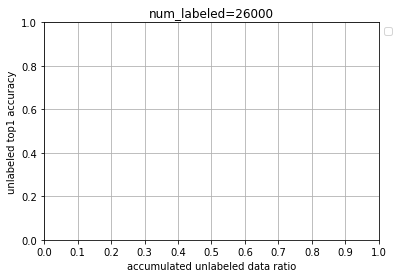

In [11]:
K = 500
num_eigenvectors = 200 # the number of precomputed spectral eigenvectors.
num_labeled = 26000
index_labeled, index_unlabeled = split_semi(num_labeled)

save_dir = os.path.join(args.save_path, 'num_labeled_%d' % num_labeled)
os.makedirs(save_dir, exist_ok=True)

n_chunks = 10
prec_top5 = AverageMeter()

chunks = index_unlabeled.chunk(n_chunks)

def worker(i_chunks):

    index_unlabeled_chunk = chunks[i_chunks]
    start = time.time()

    cache_dir = os.path.join(args.similarity_cache_dir, 'num_labeled_{}'.format(num_labeled), str(n_chunks), '{}.pth.tar'.format(i_chunks))
    d = torch.load(cache_dir)
    similarity_sorted = d['sim_sorted'][:, :K]
    idx = d['idx'][:, :K]
    n = similarity_sorted.shape[0]
    logger.info('load similarity from {} done'.format(cache_dir))
    logger.info(similarity_sorted.shape)
    logger.info(idx.shape)

    # build the sparse similarity matrix
    col = idx.numpy().flatten()
    row = np.tile(np.linspace(0,n-1,n,dtype=np.int64).reshape(-1,1),(1,K)).flatten()
    data = similarity_sorted.numpy().flatten()
    similarity_sparse = sparse.bsr_matrix((data, (row, col)), shape=(n,n))
    similarity_sparse = (similarity_sparse + similarity_sparse.T) / 2.
    logger.info('similarity_sparse done')

    # eigenvector
    degree = torch.from_numpy(np.sum(similarity_sparse, axis=0)).float()
    L_sparse = csgraph.laplacian(similarity_sparse, normed=True)
    eigenvalues, eigenvectors = linalg.eigsh(L_sparse, k=num_eigenvectors, which='SM', tol=1e-2, maxiter=30000)
    eigenvalues = eigenvalues.astype(np.float32)
    eigenvectors = eigenvectors.astype(np.float32)
    eigenvalues, eigenvectors = torch.from_numpy(eigenvalues.real)[1:], torch.from_numpy(eigenvectors.real)[:, 1:]
    eigenvalues, idx = eigenvalues.sort()
    eigenvectors = eigenvectors[:, idx]
    logger.info('eigenvectors done')

    # prior
    unary_prior = torch.zeros([n, num_class]).float()
    unary_prior[:num_labeled, :] = -1
    unary_prior[torch.arange(num_labeled), train_labels[index_labeled]] = 1
    AQ = unary_prior.abs()
    pd = degree.view(-1, 1) * (AQ + unary_prior) / 2
    nd = degree.view(-1, 1) * (AQ - unary_prior) / 2
    np_ratio = pd.sum(dim=0) / nd.sum(dim=0)
    unary_prior_norm = (pd / np_ratio).sqrt() - (nd * np_ratio).sqrt()
    unary_prior_norm = make_column_normalize(unary_prior_norm)
    logger.info('unary_prior_norm done')

    # logits and prediction
    alpha = 0
    lambda_reverse = (1 / (eigenvalues - alpha)).view(1, -1)
    logits = torch.mm(lambda_reverse * eigenvectors, torch.mm(eigenvectors.t(), unary_prior_norm))
    logits = make_column_normalize(logits) * math.sqrt(logits.shape[0])   
    logits = logits - logits.max(1, keepdim=True)[0]
    logger.info('logits done')

    _, predict = logits.max(dim=1)
    
    # pseudo weights
    logits_sorted = logits.sort(dim=1, descending=True)[0]
    subtract = logits_sorted[:, 0] - logits_sorted[:, 1]
    weights = 1 - torch.exp(- subtract)

    pseudo_weights, idx = weights[num_labeled:].sort(dim=0, descending=True)
    pseudo_indexes = index_unlabeled_chunk[idx]
    pseudo_labels = predict[num_labeled:][idx]

    save_dict = {
        'pseudo_indexes': pseudo_indexes,
        'pseudo_labels': pseudo_labels,
        'pseudo_weights': pseudo_weights,
        'labeled_indexes': index_labeled,
        'unlabeled_indexes': index_unlabeled_chunk,
    }

    torch.save(save_dict, os.path.join(save_dir, str(), '{}_{}.pth.tar'.format(n_chunks, i_chunks)))

    # plot confidence-accuracy curve
    correct = pseudo_labels == train_labels[pseudo_indexes]
    arange = 1 + np.arange(pseudo_weights.shape[0])
    xs = arange / pseudo_weights.shape[0]
    correct_sorted = correct[pseudo_weights.sort(descending=True)[1]]
    accuracies = np.cumsum(correct_sorted.numpy()) / arange
    plt.plot(xs, accuracies, label='chunk {}'.format(i_chunks))

    # print accuracies
    acc_labeled = accuracy(logits[:num_labeled], train_labels[index_labeled], topk=(1, 5))
    acc_unlabeled = accuracy(logits[num_labeled:], train_labels[index_unlabeled_chunk], topk=(1, 5))
    prec_top5.update(acc_unlabeled[1], index_unlabeled_chunk.shape[0])
    logger.info('num_labeled={:4} K={} [{}/{}], time={:.2f}, top5={:.2f}%({:.2f}%), labeled_top5={:.2f}%'.format(
        num_labeled, K, i_chunks, n_chunks, time.time() - start, prec_top5.val, prec_top5.avg, acc_labeled[1]))

Pool(n_chunks).map(worker, range(n_chunks))
    
plt.xlabel('accumulated unlabeled data ratio')
plt.ylabel('unlabeled top1 accuracy')
plt.xticks(np.arange(0, 1.01, 0.1))
plt.grid()
plt.title('num_labeled={}'.format(num_labeled))
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# test accuracies

2019-06-25 08:21:58,218 - update_title_pos
2019-06-25 08:21:58,335 - update_title_pos
2019-06-25 08:21:58,404 - update_title_pos
2019-06-25 08:21:58,435 - update_title_pos


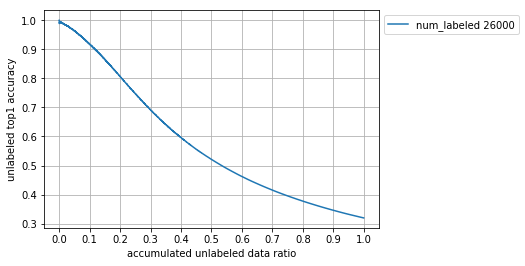

In [12]:
K = 500
num_eigenvectors = 200 # the number of precomputed spectral eigenvectors.
for num_labeled in [13000, 26000, 51000]:
    index_labeled, index_unlabeled = split_semi(num_labeled)

    save_dir = os.path.join(args.save_path, 'num_labeled_%d' % num_labeled)
    os.makedirs(save_dir, exist_ok=True)

    n_chunks = 10
    prec_top5 = AverageMeter()

    chunks = index_unlabeled.chunk(n_chunks)

    pseudo_weights = []
    correct = []
    for i_chunks in range(n_chunks):
        save_dict = torch.load(os.path.join(save_dir, str(), '{}_{}.pth.tar'.format(n_chunks, i_chunks)))
        
        pseudo_weights.append(save_dict['pseudo_weights'])
        correct.append(save_dict['pseudo_labels'] == train_labels[save_dict['pseudo_indexes']])
    pseudo_weights = torch.cat(pseudo_weights) 
    correct = torch.cat(correct)
    
    # plot confidence-accuracy curve
    pseudo_weights, idx = pseudo_weights.sort(dim=0, descending=True)
    correct = correct[idx]
    arange = 1 + np.arange(pseudo_weights.shape[0])
    xs = arange / pseudo_weights.shape[0]
    correct_sorted = correct[pseudo_weights.sort(descending=True)[1]]
    accuracies = np.cumsum(correct_sorted.numpy()) / arange
    plt.plot(xs, accuracies, label='num_labeled {}'.format(num_labeled))

plt.xlabel('accumulated unlabeled data ratio')
plt.ylabel('unlabeled top1 accuracy')
plt.xticks(np.arange(0, 1.01, 0.1))
plt.grid()
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()